In [195]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from datetime import datetime, timedelta

%matplotlib inline


In [3]:
df = pd.read_excel('../data/total_full_month.xlsx')


In [4]:
df.head()

,DT,cnt
0,2020-01-01,3483
1,2020-01-02,3270
2,2020-01-03,5583
3,2020-01-04,5570
4,2020-01-05,3707


In [5]:
df['week_day_num'] = df['DT'].dt.strftime('%w')
df['month_day_num'] = df['DT'].dt.strftime('%#d')
df['month_num'] = df['DT'].dt.strftime('%#m')


In [6]:
df.head()

,DT,cnt,week_day_num,month_day_num,month_num
0,2020-01-01,3483,3,1,1
1,2020-01-02,3270,4,2,1
2,2020-01-03,5583,5,3,1
3,2020-01-04,5570,6,4,1
4,2020-01-05,3707,0,5,1


In [7]:
df.describe()

,cnt
count,1035.000000
mean,2851.699517
std,1125.248221
min,1170.000000
25%,2143.500000
50%,2552.000000
75%,3244.500000
max,12195.000000


In [232]:
std_scaler = StandardScaler()
df['cnt'] = std_scaler.fit_transform(np.array(df[['cnt']]))
df.tail()

,DT,cnt,week_day_num,month_day_num,month_num
1030,2022-10-27,-0.489639,4,27,10
1031,2022-10-28,-0.378499,5,28,10
1032,2022-10-29,-0.871073,6,29,10
1033,2022-10-30,-0.737704,0,30,10
1034,2022-10-31,0.065173,1,31,10


In [9]:
df.describe()

,cnt
count,1.035000e+03
mean,1.098424e-16
std,1.000483e+00
min,-1.495237e+00
25%,-6.296761e-01
50%,-2.664696e-01
75%,3.492477e-01
max,8.307338e+00


In [155]:
X = df[['week_day_num', 'month_day_num', 'month_num']].values.astype(float)
X_with_calls = np.copy(X)
X_with_calls = np.delete(X_with_calls, (0), axis=0)
X, X_with_calls

(array([[ 3.,  1.,  1.],
        [ 4.,  2.,  1.],
        [ 5.,  3.,  1.],
        ...,
        [ 6., 29., 10.],
        [ 0., 30., 10.],
        [ 1., 31., 10.]]),
 array([[ 4.,  2.,  1.],
        [ 5.,  3.,  1.],
        [ 6.,  4.,  1.],
        ...,
        [ 6., 29., 10.],
        [ 0., 30., 10.],
        [ 1., 31., 10.]]))

In [156]:
x_axis = df.index.values

In [157]:
y = df[['cnt']].values
y_for_train = y[1::]
y_for_x = y[:-1:]
y, y_for_train, y_for_x

(array([[ 0.56130342],
        [ 0.37192035],
        [ 2.42846055],
        ...,
        [-0.87107282],
        [-0.73770446],
        [ 0.0651731 ]]),
 array([[ 0.37192035],
        [ 2.42846055],
        [ 2.41690195],
        ...,
        [-0.87107282],
        [-0.73770446],
        [ 0.0651731 ]]),
 array([[ 0.56130342],
        [ 0.37192035],
        [ 2.42846055],
        ...,
        [-0.37849899],
        [-0.87107282],
        [-0.73770446]]))

In [158]:
X_with_calls = np.append(X_with_calls, y_for_x, axis=1)
X_with_calls.shape

(1034, 4)

In [159]:
X_with_calls

array([[ 4.        ,  2.        ,  1.        ,  0.56130342],
       [ 5.        ,  3.        ,  1.        ,  0.37192035],
       [ 6.        ,  4.        ,  1.        ,  2.42846055],
       ...,
       [ 6.        , 29.        , 10.        , -0.37849899],
       [ 0.        , 30.        , 10.        , -0.87107282],
       [ 1.        , 31.        , 10.        , -0.73770446]])

In [160]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_test, y_train, y_test = train_test_split(X_with_calls, y_for_train, test_size=0.2, random_state=12)

In [428]:
%%capture
model = keras.Sequential()
model.add(layers.Dense(7, input_dim=4, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, epochs=400)

In [429]:
scores = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 667us/step - loss: 0.3481


33/33 [==============================] - 0s 532us/step


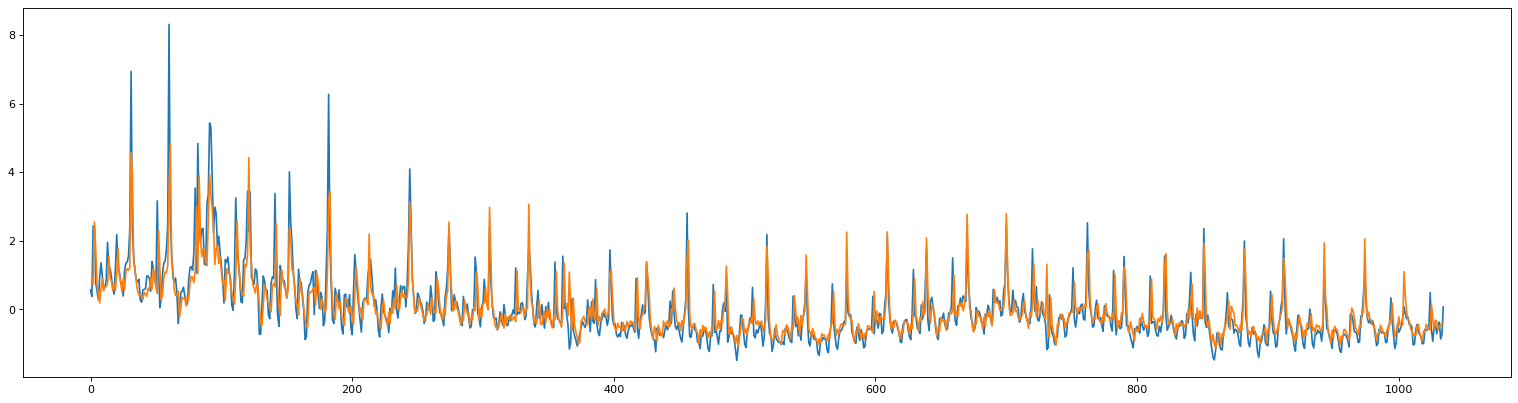

In [430]:
y_pred = model.predict(X_with_calls)
plt.figure(figsize=(24, 6), dpi=80)
plt.plot(x_axis, y)
plt.plot(x_axis[1::], y_pred)

In [431]:
def predict(days):
    rez = []
    params = np.array([ 2., 1., 11., 0.0651731])
    for day in range(days):
        predict = model.predict(params.reshape(1, 4), verbose=0)
        rez.append(predict[0][0])
        params = next_params(day, predict)
    return np.array(rez).reshape(-1, 1)

def next_params(day, predict):
    start_date = datetime(2022, 11, 1)
    next_date = start_date + timedelta(days=day)
    params = np.array([float(next_date.strftime('%w')),
                      float(next_date.strftime('%#d')),
                      float(next_date.strftime('%#m')),
                      predict[0][0]])
    return params


In [432]:
days = 365
future_pred = predict(days)

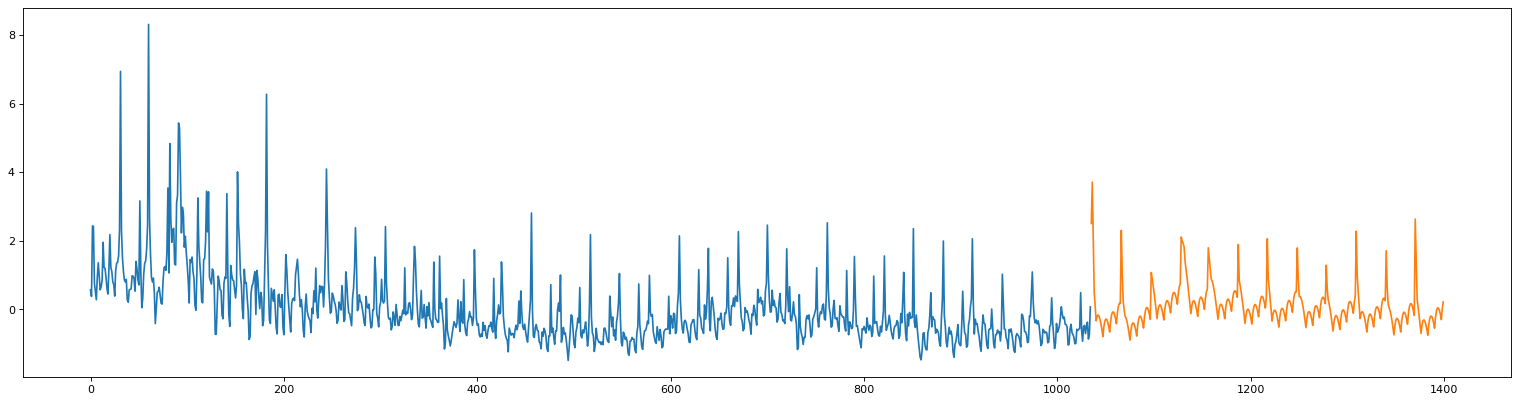

In [433]:
future_x = np.arange(len(x_axis), len(x_axis) + days)
future_x
plt.figure(figsize=(24, 6), dpi=80)
plt.plot(x_axis, y)
plt.plot(future_x, future_pred)

In [434]:
model.save('simple_dense_model')

INFO:tensorflow:Assets written to: simple_dense_model\assets
